# **Import Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
import os
cwd = os.getcwd()
from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# **Load the Cracks Data set**
[https://data.mendeley.com/datasets/5y9wdsg2zt/2


In [ ]:
crack_images = os.listdir('Positive/')
print("Number of Crack Images: ", len(crack_images))

Number of Crack Images:  60


In [ ]:
no_crack_images = os.listdir('Negative/')
print("Number of No Crack Images: ", len(no_crack_images))

Number of No Crack Images:  60


# **Visualize Random images with cracks**

*****************Random Images with Cracks**************************


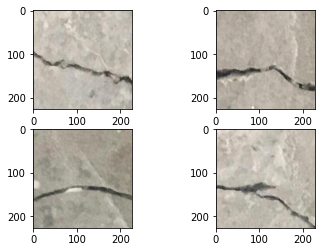

In [ ]:
## Visualize Random images with cracks
random_indices = np.random.randint(0, len(crack_images), size=4)
print("*****************Random Images with Cracks**************************")
random_images = np.array(crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[3])))

# **Visualize Random images with no cracks**

*****************Random Images without Cracks**************************


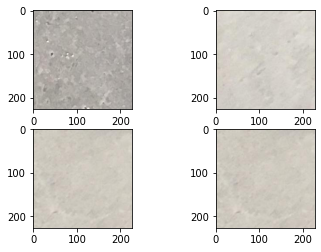

In [ ]:
## Visualize Random images with no cracks
random_indices = np.random.randint(0, len(no_crack_images), size=4)
print("*****************Random Images without Cracks**************************")
random_images = np.array(no_crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[3])))

# **Create Train and Val Data sets**



In [ ]:
base_dir = cwd
files = os.listdir(base_dir)

def create_training_data(folder_name):
    train_dir = f"{base_dir}/train/{folder_name}"
    for f in files:
        search_object = re.search(folder_name, f)
        if search_object:
            shutil.move(f'{base_dir}/{folder_name}', train_dir)

In [ ]:
create_training_data('Positive')
create_training_data('Negative')

# **Move images randomly from training to val folders**


In [ ]:
os.makedirs('val/Positive')
os.makedirs('val/Negative')

In [ ]:
positive_train = base_dir + "/train/Positive/"
positive_val = base_dir + "/val/Positive/"
negative_train = base_dir + "/train/Negative/"
negative_val = base_dir + "/val/Negative/"

positive_files = os.listdir(positive_train)
negative_files = os.listdir(negative_train)

In [ ]:
print(len(positive_files), len(negative_files))

60 60


In [ ]:
for f in positive_files:
    if random.random() > 0.80:
        shutil.move(f'{positive_train}/{f}', positive_val)

In [ ]:
for f in negative_files:
    if random.random() > 0.80:
        shutil.move(f'{negative_train}/{f}', negative_val)

# **Pytorch data loader and transforms**

#**Compute mean and std deviation for the dataset**

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

#**Define data augmentation and transforms**

In [ ]:
## Define data augmentation and transforms
chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=227),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
## Create the data loader
def load_dataset(format, batch_size):
    data_path = os.path.join(cwd, format)
    dataset = datasets.ImageFolder(
        root=data_path,
        transform= chosen_transforms[format]
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        shuffle=True
    )
    return data_loader, len(dataset), dataset.classes

In [ ]:
## Set code to run on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
train_loader, train_size, class_names = load_dataset('train', 8)
print("Train Data Set size is: ", train_size)
print("Class Names are: ", class_names)
inputs, classes = next(iter(train_loader))
print(inputs.shape, classes.shape)

Train Data Set size is:  88
Class Names are:  ['Negative', 'Positive']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([8, 3, 227, 227]) torch.Size([8])


In [ ]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


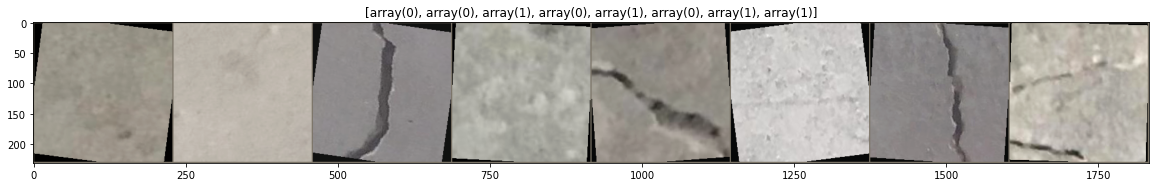

In [ ]:
# Grab some of the training data to visualize
inputs, classes = next(iter(train_loader))
# class_names = chosen_datasets['train'].classes
# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

idx_to_class = {0:'Negative', 1:'Positive'}
plt.figure(figsize=(20,10))
imshow(out, title=[x.data.numpy() for x in classes])

# **Install TVM**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/data/tvm-main.zip

Archive:  gdrive/My Drive/data/tvm-main.zip
217763279371bc8eec4b61152e8b2deaef4b8a8c
   creating: tvm-main/
  inflating: tvm-main/.asf.yaml      
  inflating: tvm-main/.clang-format  
   creating: tvm-main/.github/
  inflating: tvm-main/.github/CODEOWNERS  
   creating: tvm-main/.github/ISSUE_TEMPLATE/
  inflating: tvm-main/.github/ISSUE_TEMPLATE/bug-report.md  
  inflating: tvm-main/.github/ISSUE_TEMPLATE/ci-image.md  
  inflating: tvm-main/.github/ISSUE_TEMPLATE/ci-problem.md  
  inflating: tvm-main/.github/ISSUE_TEMPLATE/config.yml  
  inflating: tvm-main/.github/ISSUE_TEMPLATE/documentation.md  
  inflating: tvm-main/.github/ISSUE_TEMPLATE/feature-tracking.md  
  inflating: tvm-main/.github/PULL_REQUEST_TEMPLATE.md  
   creating: tvm-main/.github/workflows/
  inflating: tvm-main/.github/workflows/main.yml  
  inflating: tvm-main/.gitignore     
  inflating: tvm-main/.gitmodules    
  inflating: tvm-main/.pre-commit-config.yaml  
   creating: tvm-main/3rdparty/
   creating: tvm-main

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:

    ! gsutil cp "gs://tvm-fcrc-binariesd5fce43e-8373-11e9-bfb6-0242ac1c0002/tvm.tar.gz" /tmp/tvm.tar.gz
    ! mkdir -p /tvm
    ! tar -xf /tmp/tvm.tar.gz --strip-components=4 --directory /tvm
    ! ls -la /tvm
    ! bash /tvm/package.sh
    # Add TVM to the Python path.
    import sys
    sys.path.append('/tvm/python')
    sys.path.append('/tvm/topi/python')
    sys.path.append('/tvm/nnvm/python')
    sys.path.append('/tvm/vta/python')
else:
    print("Notebook executing locally, skipping Colab setup ...")

Copying gs://tvm-fcrc-binariesd5fce43e-8373-11e9-bfb6-0242ac1c0002/tvm.tar.gz...
/ [1 files][119.5 MiB/119.5 MiB]                                                
Operation completed over 1 objects/119.5 MiB.                                    
total 164
drwxr-xr-x 21 root root  4096 Oct 14 13:58 .
drwxr-xr-x  1 root root  4096 Oct 14 13:58 ..
drwx------  8 root root  4096 May 31  2019 3rdparty
drwx------ 12 root root  4096 May 31  2019 apps
drwx------  3 root root  4096 Jun 19  2019 build
drwx------  4 root root  4096 May 31  2019 cmake
-rw-------  1 root root 11053 Jun 19  2019 CMakeLists.txt
drwx------  6 root root  4096 May 31  2019 conda
-rw-------  1 root root  5736 Jun 19  2019 CONTRIBUTORS.md
drwx------  3 root root  4096 May 31  2019 docker
drwx------ 11 root root  4096 May 31  2019 docs
drwx------  4 root root  4096 May 31  2019 golang
drwx------  3 root root  4096 May 31  2019 include
-rw-------  1 root root 10607 Jun 19  2019 Jenkinsfile
drwx------  6 root root  4096 May 31 

In [ ]:
import sys
sys.path.append('/tvm/python')
sys.path.append('/tvm/python/tvm/relay/frontend/')
sys.path.append('/tvm/topi/python')
sys.path.append('/tvm/nnvm/python')
sys.path.append('/tvm/vta/python')

In [ ]:
import tvm
from tvm import relay

In [ ]:
tvm.relay.frontend.

In [ ]:
tvm.relay.frontend.

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    ! gsutil cp "gs://tvm-fcrc-binariesd5fce43e-8373-11e9-bfb6-0242ac1c0002/tvm.tar.gz" /tmp/tvm.tar.gz
    ! mkdir -p /tvm
    ! tar -xf /tmp/tvm.tar.gz --strip-components=4 --directory /tvm
    ! ls -la /tvm
    ! bash /tvm/package.sh
    ! pip install onnx
    ! sudo apt install clang-format
    # ! pip install https://download.pytorch.org/whl/cu100/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
    # ! pip3 install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl
    # Add TVM to the Python path.
    import sys
    import os
    sys.path.append('/tvm/python')
    sys.path.append('/tvm/topi/python')
    sys.path.append('/tvm/vta/python')
    os.environ['TVM_HOME'] = '/tvm'
else:
    print("Notebook executing locally, skipping Colab setup ...")

Copying gs://tvm-fcrc-binariesd5fce43e-8373-11e9-bfb6-0242ac1c0002/tvm.tar.gz...
\ [1 files][119.5 MiB/119.5 MiB]                                                
Operation completed over 1 objects/119.5 MiB.                                    
total 164
drwxr-xr-x 21 root root  4096 Oct 12 21:31 .
drwxr-xr-x  1 root root  4096 Oct 12 20:23 ..
drwx------  8 root root  4096 May 31  2019 3rdparty
drwx------ 12 root root  4096 May 31  2019 apps
drwx------  3 root root  4096 Jun 19  2019 build
drwx------  4 root root  4096 May 31  2019 cmake
-rw-------  1 root root 11053 Jun 19  2019 CMakeLists.txt
drwx------  6 root root  4096 May 31  2019 conda
-rw-------  1 root root  5736 Jun 19  2019 CONTRIBUTORS.md
drwx------  3 root root  4096 May 31  2019 docker
drwx------ 11 root root  4096 May 31  2019 docs
drwx------  4 root root  4096 May 31  2019 golang
drwx------  3 root root  4096 May 31  2019 include
-rw-------  1 root root 10607 Jun 19  2019 Jenkinsfile
drwx------  6 root root  4096 May 31 

In [ ]:
#!git clone --recursive https://github.com/apache/tvm tvm

!git clone --recursive https://github.com/apache/tvm.git

fatal: destination path 'tvm' already exists and is not an empty directory.


In [ ]:
!pip uninstall tvm


In [ ]:

#from tvm import relay
#from tvm.relay import testing
import tvm
#from tvm import te
#from tvm.contrib import graph_runtime
#import tvm.testing
#import tvm.relay
import torch
import torchvision
import os, psutil

import numpy as np
#def tvm_build():
input_name = "input0"
shape = [1, 3, 224, 224]
data = torch.randn(shape, dtype=torch.float32)
model = torchvision.models.resnet50(pretrained=False, progress=True)

shape_list = [(input_name, data.shape)]
scripted_model = torch.jit.trace(model, data).eval()
mod, params = tvm.relay.frontend.from_pytorch(scripted_model, shape_list)

# TODO: how opt_level affects performance
opt_level = 3
with tvm.transform.PassContext(opt_level=opt_level):
    lib = relay.build(mod,
                        target='llvm',
                        target_host='llvm',
                        params=params)

ctx = tvm.cpu()
module = graph_runtime.GraphModule(lib["default"](ctx))
module.set_input(input_name, data)






In [ ]:
process = psutil.Process(os.getpid())
#print('Used Memory before building:', process.memory_info().rss / 1024 / 1024, 'MB')
tvm_build()
print('Used Memory after building times:', process.memory_info().rss / 1024 / 1024, 'MB')

In [ ]:
import os, psutil

import numpy as np
#from tvm import relay

import tvm.relay as relay


from tvm.relay import testing
import tvm
#from tvm import te
from tvm.contrib import graph_runtime
import tvm.testing
import torch
import torchvision

def tvm_build():
    input_name = "input0"
    shape = [1, 3, 227, 227]
    data = torch.randn(shape, dtype=torch.float32)
    ## Load pretrained model
    resnet50 = models.resnet50(pretrained=False, progress=True)

    shape_list = [(input_name, data.shape)]
    scripted_model = torch.jit.trace(resnet50, data).eval()
    mod, params = relay.frontend.from_pytorch(scripted_model, shape_list)

        # Freeze model parameters
    for param in params:
        param.requires_grad = False

    ## Change the final layer of the resnet model
    # Change the final layer of ResNet50 Model for Transfer Learning
    fc_inputs = resnet50.fc.in_features

    resnet50.fc = nn.Sequential(
        nn.Linear(fc_inputs, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, 2)
    )

    # Convert model to be used on GPU
    resnet50 = resnet50.to(device)

    from torchsummary import summary
    print(summary(resnet50, (3, 227, 227)))


    # TODO: how opt_level affects performance
    opt_level = 3
    with tvm.transform.PassContext(opt_level=opt_level):
        lib = relay.build(mod,
                            target='llvm',
                            target_host='llvm',
                            params=params)

    ctx = tvm.cpu()
    module = graph_runtime.GraphModule(lib["default"](ctx))
    module.set_input(input_name, data)



process = psutil.Process(os.getpid())
print('Used Memory before building:', process.memory_info().rss / 1024 / 1024, 'MB')

total = 0
for i in range(0, total+1):
    tvm_build()
    print('Used Memory after building {} times:'.format(i+1), process.memory_info().rss / 1024 / 1024, 'MB')



Used Memory before building: 1617.5703125 MB


AttributeError: ignored

In [ ]:
# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters())
# optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
dataloaders = {}
dataset_sizes = {}
batch_size = 256
dataloaders['train'], dataset_sizes['train'], class_names = load_dataset('train', batch_size)
dataloaders['val'], dataset_sizes['val'], _ = load_dataset('val', batch_size)
idx_to_class = {0:'Negative', 1:'Positive'}

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
base_model = train_model(resnet50, criterion, optimizer, exp_lr_scheduler, num_epochs=6)
visualize_model(base_model)
plt.show()

# **Inference**

In [ ]:
def predict(model, test_image, print_class = False):

    transform = chosen_transforms['val']

    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227)

    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        class_name = idx_to_class[topclass.cpu().numpy()[0][0]]
        if print_class:
            print("Output class :  ", class_name)
    return class_name

In [ ]:
def predict_on_crops(input_image, height=227, width=227, save_crops = False):
    im = cv2.imread(input_image)
    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            ## discard image cropss that are not full size
            predicted_class = predict(base_model,Image.fromarray(a))
            ## save image
            file, ext = os.path.splitext(input_image)
            image_name = file.split('/')[-1]
            folder_name = 'out_' + image_name
            ## Put predicted class on the image
            if predicted_class == 'Positive':
                color = (0,0, 255)
            else:
                color = (0, 255, 0)
            cv2.putText(a, predicted_class, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA)
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            ## Save crops
            if save_crops:
                if not os.path.exists(os.path.join('real_images', folder_name)):
                    os.makedirs(os.path.join('real_images', folder_name))
                filename = os.path.join('real_images', folder_name,'img_{}.png'.format(k))
                cv2.imwrite(filename, add_img)
            output_image[i:i+height, j:j+width,:] = add_img
            k+=1
    ## Save output image
    cv2.imwrite(os.path.join('real_images','predictions', folder_name+ '.jpg'), output_image)
    return output_image

In [ ]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('real_images/concrete_crack2.jpg')
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

In [ ]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('real_images/road_surface_crack1.jpg', 128,128)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

In [ ]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('real_images/road_surface_crack3.jpg',128,128)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))